(ortools-number-link)=
# ナンバーリンクパズル

[前章](z3-number-link)では、Z3を使用してナンバーリンクパズルを解きました。Z3には回路を作成するための専用の制約条件がないため、開発者は自分で類似の制約条件を作成する必要があります。一方、本章では、CP-SATの `add_circuit()` を利用し、回路の制約条件を簡単に設定することで、ナンバーリンクパズルを解く方法を紹介します。  

In [3]:
import numpy as np
from ortools.sat.python import cp_model
from helper.ortools import get_circuit

それでは、次のパズルを解いてみましょう。

In [4]:
board = np.loadtxt('data/numberlink01.txt', dtype=np.uint8)
print(board)

[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 6 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 4 3 0 0 0]
 [0 0 0 0 0 0 6 0 5 0]
 [0 8 0 3 0 0 0 0 0 0]
 [0 0 0 4 7 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 8 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2]]


## 解き方

ナンバーリンクパズルを`add_circuit()`を用いて解く方法を説明します。このパズルでは、同じ数字のペアをつなぐルートを見つける必要がありますが、全てのマスを通る必要はありません。そこで、次のような方法を採用します。

1. **数字のペアごとに1つの回路を対応させる**  
   - すべての頂点（マス）を通る必要がないため、 **自己ループ** `(頂点番号, 頂点番号, 頂点変数)` を追加します。これにより、特定の頂点がルートから除外されることを許可できます。  
   - 数字のペアに対応する頂点番号を`n1`と`n2`とした場合、これらを必ず結ぶための辺`(n2, n1, True)`を追加します。

2. **各頂点は1つの回路にのみ属する制約を追加する**  
   - 各マスには複数の数字のペアが通る可能性があるため、それぞれのペアに対して異なる回路を割り当てます。  
   - しかし、1つのマスは1つの回路にしか属せないため、自己ループの変数が `True` の場合、そのマスはその数字の回路に含まれません。そのため、自己ループの変数のうち1つだけを `False` にする制約を追加します。これにより、あるマスが1つの回路にのみ割り当てられ、それ以外の回路には含まれないことを保証します。

次の`create_nodes_edges(board)`は盤面 (board) を受け取り、盤面上の各マスに対応するインデックス情報 (nodes) と、それぞれのマスを隣接するマスと結ぶ辺 (edges) を作成します。次の二つデータを返します。

- `nodes`：各マスのインデックスを持つ2次元配列  
- `edges`：隣接するマス同士を結ぶ辺のリスト  

In [5]:
def create_nodes_edges(board):
    h, w = board.shape
    nodes = np.arange(w * h).reshape((h, w))
    edges = []
    for r in range(h):
        for c in range(w):
            node = nodes[r, c]
            if c + 1 < w:
                right = nodes[r, c + 1]
                edges.extend([(node, right), (right, node)])
            if r + 1 < h:
                bottom = nodes[r + 1, c]
                edges.extend([(node, bottom), (bottom, node)])
    return nodes, edges

次の`solve_number_link(board)`関数でナンバーリンクパズルを解きます。

1. 各数字ごとに回路を作成
   - `number_starts`：各数字の開始地点（1つ目の位置）  
   - `layers_circuits`：各数字ごとの辺とブール変数の対応  
   - `layers_nodes`：各数字ごとの自己ループの変数  

2. 各マスに対する制約
   - 1つのマスは1つの回路にしか属せないようにする制約を`model.add_exactly_one()`で追加します。

3. 解を求め、結果を表示
   - ヘルプ関数`get_circuit()` を用いて各回路の経路を取得し、結果のグリッドを表示します。

In [6]:
def solve_number_link(board):
    h, w = board.shape
    model = cp_model.CpModel()
    nodes, edges = create_nodes_edges(board)
    
    number_starts = {}
    layers_circuits = {}
    layers_nodes = {}
    
    for n in range(1, board.max() + 1):
        r, c = np.where(board == n)
        loc1 = r[0], c[0]
        loc2 = r[1], c[1]
        node1 = nodes[loc1]
        node2 = nodes[loc2]
    
        circuit_variables = [(s, t, model.new_bool_var(f"{n}_{s}_{t}")) for s, t in edges]
        node_variables = [(s, s, model.new_bool_var(f"{n}_{s}_{s}")) for s in nodes.ravel()]
    
        model.add_circuit(circuit_variables + node_variables + [(node2, node1, True)])
        number_starts[n] = node1
    
        layers_circuits[n] = circuit_variables
        layers_nodes[n] = node_variables
    
    for node in nodes.ravel():
        variables = [value[node][2] for value in layers_nodes.values()]
        model.add_exactly_one([~v for v in variables])
    
    solver = cp_model.CpSolver()
    solver.solve(model)

    links = {}
    cells = {}
    for key, circuits in layers_circuits.items():
        solution = {(s, t):solver.value(v) for s, t, v in circuits}
        nodes = get_circuit(solution, start=number_starts[key])
        nodes = [(n // w, n % w) for n in nodes]
        for n in nodes:
            cells[n] = key
        for n1, n2 in zip(nodes[:-1], nodes[1:]):
            links[n1 + n2] = True
    return links, cells

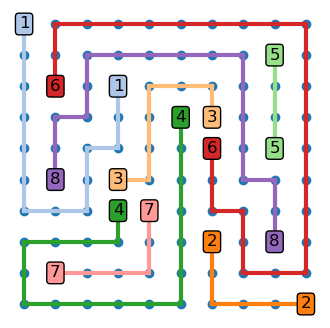

In [8]:
from helper.plot import plot_number_link_board
links, cells = solve_number_link(board)
plot_number_link_board(board, links, cells);

## 複雑なパズル

次は複雑なパズルに挑戦してみます。

CPU times: total: 14.5 s
Wall time: 5.65 s


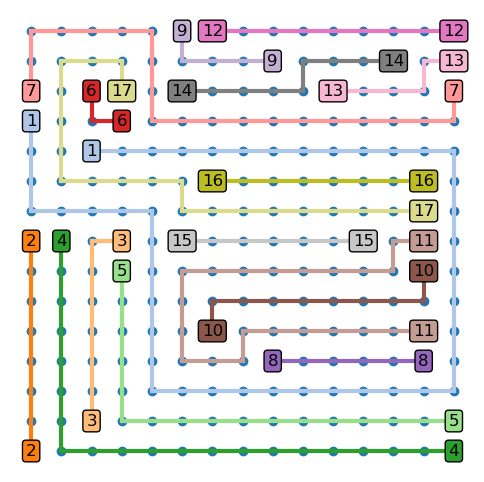

In [9]:
%%time
board = np.loadtxt('data/numberlink02.txt', dtype=np.uint8)
links, cells = solve_number_link(board)
plot_number_link_board(board, links, cells);